In [57]:
#Libraries
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime
import seaborn as sns
import joblib

In [58]:
# Test Dataset imported

file_name = 'bq-results-20230508-120532-1683547582745.csv'
test_data = pd.read_csv(file_name, index_col=False, parse_dates=['tiemstamp_AEST'])
test_data.sort_values(by=['userID', 'tiemstamp_AEST'], inplace = True)

In [59]:
#Time feature engineering

test_data.reset_index(drop = True, inplace = True)

#Create Session Data
test_data['SessionID'] = np.nan
counter = 1
test_data['SessionID'][0] = counter
for i in range(1,len(test_data['distance'])):
    if test_data['distance'][i] < test_data['distance'][i-1] or test_data['tiemstamp_AEST'][i].day != test_data['tiemstamp_AEST'][i-1].day:
        counter += 1
    test_data['SessionID'][i] = counter

<ipython-input-59-3192067ea913>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SessionID'][0] = counter
<ipython-input-59-3192067ea913>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SessionID'][i] = counter


In [60]:
#Get session fundamentals

test_data = test_data.drop(columns=['userID'])

#Averages
td_avg = test_data.groupby('SessionID').mean()

#Maxes
td_max = test_data.groupby('SessionID').max()

#Session Length
td_length = test_data.groupby('SessionID').max()-test_data.groupby('SessionID').min()

#Lock required features
td_avg = td_avg[['enhanced_speed','heart_rate', 'cadence', 'power']]
td_max = td_max[['distance','ascent']]
td_length = td_length[['tiemstamp_AEST']]

#Convert time to session length in minutes
for i in range(1, len(td_length['tiemstamp_AEST'])+1):
    td_length['tiemstamp_AEST'][i] = (td_length['tiemstamp_AEST'][i].total_seconds())/60

td_length = td_length.rename(columns={"tiemstamp_AEST": "Length"})

td_length = td_length.astype(float)

#Combine feature types
td_comb = pd.concat([td_avg, td_max, td_length], axis=1)
td_comb = round(td_comb,2) 

td_comb = td_comb[td_comb['Length'] < 400]

scaler = StandardScaler()
scaler.fit(td_comb)
st_df = scaler.transform(td_comb)

In [61]:
#Silhouette Scores
#Another method of determining number of clusters
#Measures how similar datapoints are in a cluster compared to other clusters

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters,  init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)
    
    silhouette_avg = silhouette_score(st_df, cluster_labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.324744423108969
For n_clusters = 3 The average silhouette_score is : 0.38264331680285935
For n_clusters = 4 The average silhouette_score is : 0.3228463249380932
For n_clusters = 5 The average silhouette_score is : 0.25892144289046365
For n_clusters = 6 The average silhouette_score is : 0.23048504886419408
For n_clusters = 7 The average silhouette_score is : 0.26252160851605155


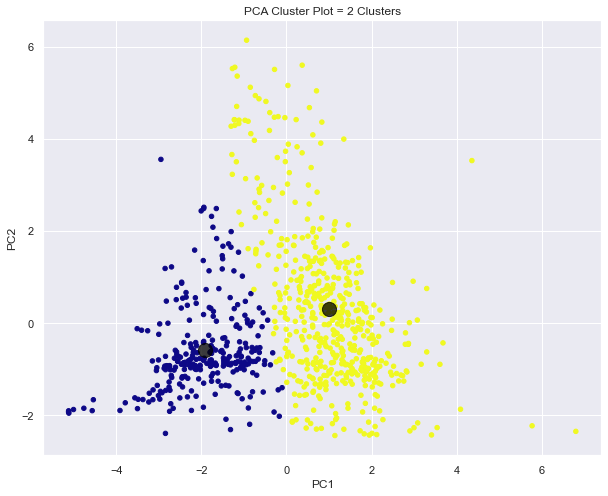

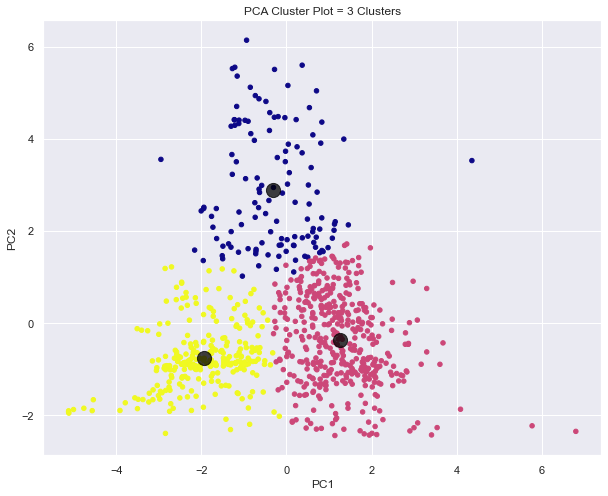

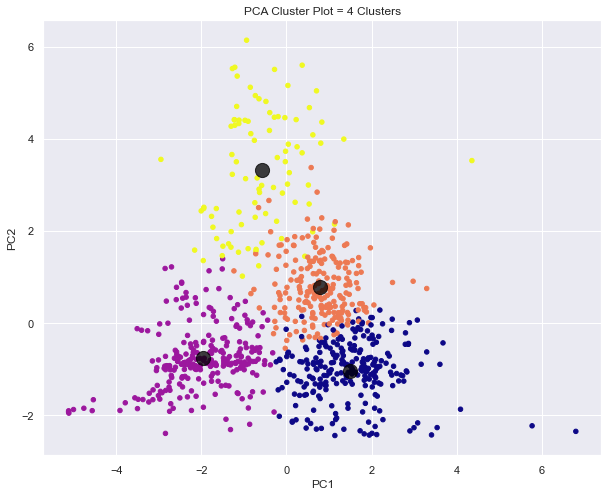

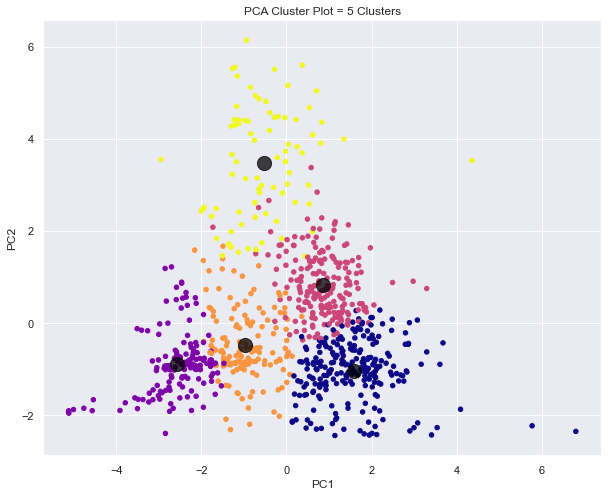

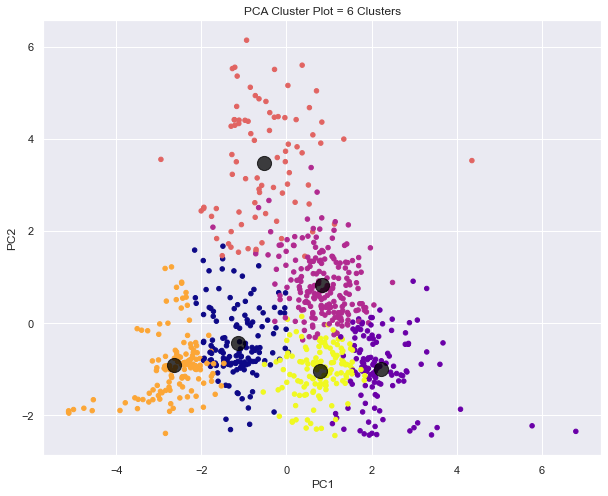

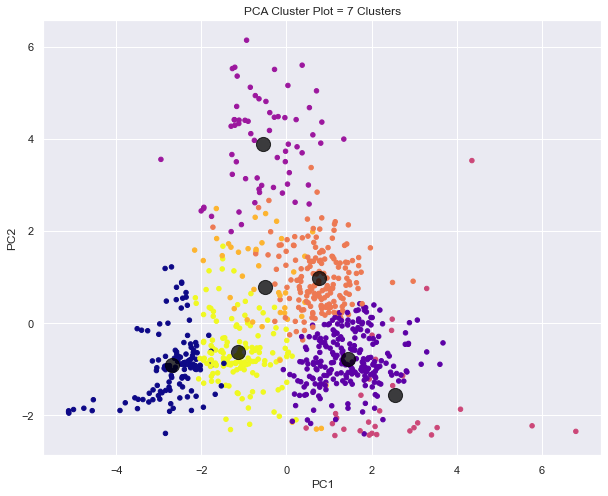

In [62]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(st_df)

# Transfor the scaled data to the new PCA space
st_df_red = pca.transform(st_df)

# Plot Clusters Example (Power v. Distance)
range_n_clusters = range(2,8)
    
for n_clusters in range_n_clusters: 
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)

    df_red = pd.DataFrame(st_df_red, index=td_comb.index, columns=['PC1','PC2'])
    df_red['cluster'] = cluster_labels
    df_red_centre = pca.transform(clusterer.cluster_centers_)

    mp.scatter(df_red['PC1'], df_red['PC2'], c=cluster_labels, s=20, cmap='plasma')
    mp.title("PCA Cluster Plot = " + str(n_clusters) + " Clusters", loc='center')

    mp.scatter(df_red_centre[:, 0], df_red_centre[:, 1], c='black', s=200, alpha=0.75);
    mp.xlabel("PC1")
    mp.ylabel("PC2")
    mp.show()


In [94]:
#Table representation of feature overlap across clusters.
#
#K-means Parameter loop
n_clusters = 4


clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=10)
cluster_labels = clusterer.fit_predict(st_df)

td_comb.insert(0, "Cluster", cluster_labels, True)

#Data means/median/count
print("Clusters = " + str(len(set(cluster_labels))))
print("Distance")
print(round(td_comb.groupby('Cluster')['distance'].describe(),2))
print("Power")
print(round(td_comb.groupby('Cluster')['power'].describe(),2))
print("Length")
print(round(td_comb.groupby('Cluster')['Length'].describe(),2))
print("Ascent")
print(round(td_comb.groupby('Cluster')['ascent'].describe(),2))
td_comb = td_comb.drop(columns=["Cluster"])

Clusters = 4
Distance
         count   mean    std    min    25%    50%     75%     max
Cluster                                                          
0        254.0  23.44  10.26   0.02  19.04  24.14   30.32   45.15
1        253.0  34.13  13.22   1.79  27.33  34.02   38.33   80.61
2        217.0  54.32  14.18  23.50  43.25  52.22   61.41  118.52
3         88.0  86.50  24.22  41.83  68.25  85.66  103.12  166.99
Power
         count    mean    std    min     25%     50%     75%     max
Cluster                                                             
0        254.0  125.12  24.10   0.00  111.63  125.62  137.84  210.92
1        253.0  208.52  28.49  57.19  196.89  212.66  224.52  298.22
2        217.0  141.57  21.02  82.83  129.91  136.85  143.59  236.21
3         88.0  170.60  31.58  19.07  161.67  173.04  187.00  222.42
Length
         count    mean    std     min     25%     50%     75%     max
Cluster                                                              
0        254.0 

In [91]:
#Graph the data
gp_data = td_comb.copy()
gp_data.insert(0, "Cluster", cluster_labels, True)

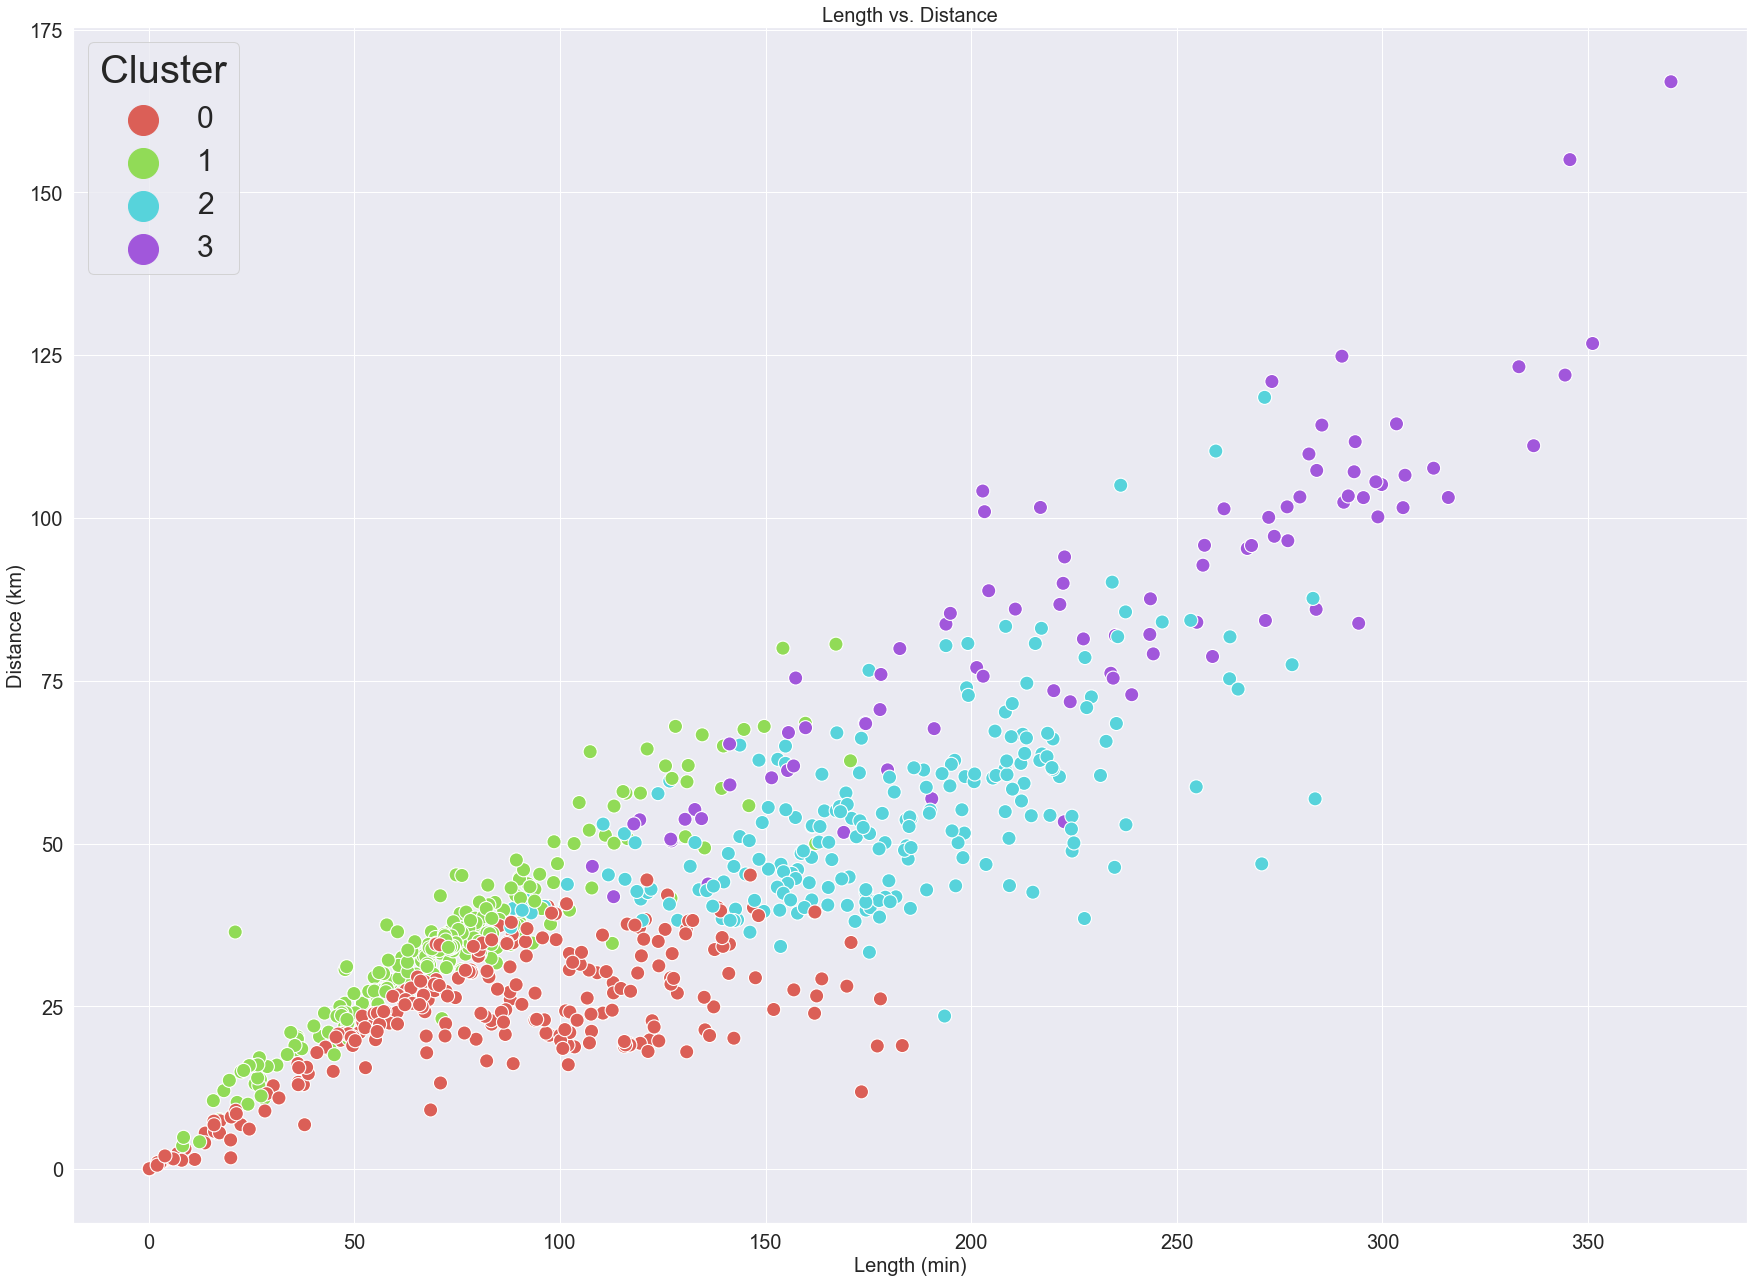

In [97]:
plot = sns.scatterplot(x=gp_data.Length,y=gp_data.distance,hue=gp_data.Cluster,
                palette=sns.color_palette("hls",n_clusters),data=gp_data, legend="full", s=200)
sns.set(rc={"figure.figsize":(30, 22)})
plot.axes.set_title("Length vs. Distance", fontsize=20)
plot.set_xlabel("Length (min)", fontsize=20)
plot.set_ylabel("Distance (km)", fontsize=20)
plot.legend(title='Cluster', fontsize='30', title_fontsize='40', markerscale=5)
plot.tick_params(labelsize=20)
mp.show()

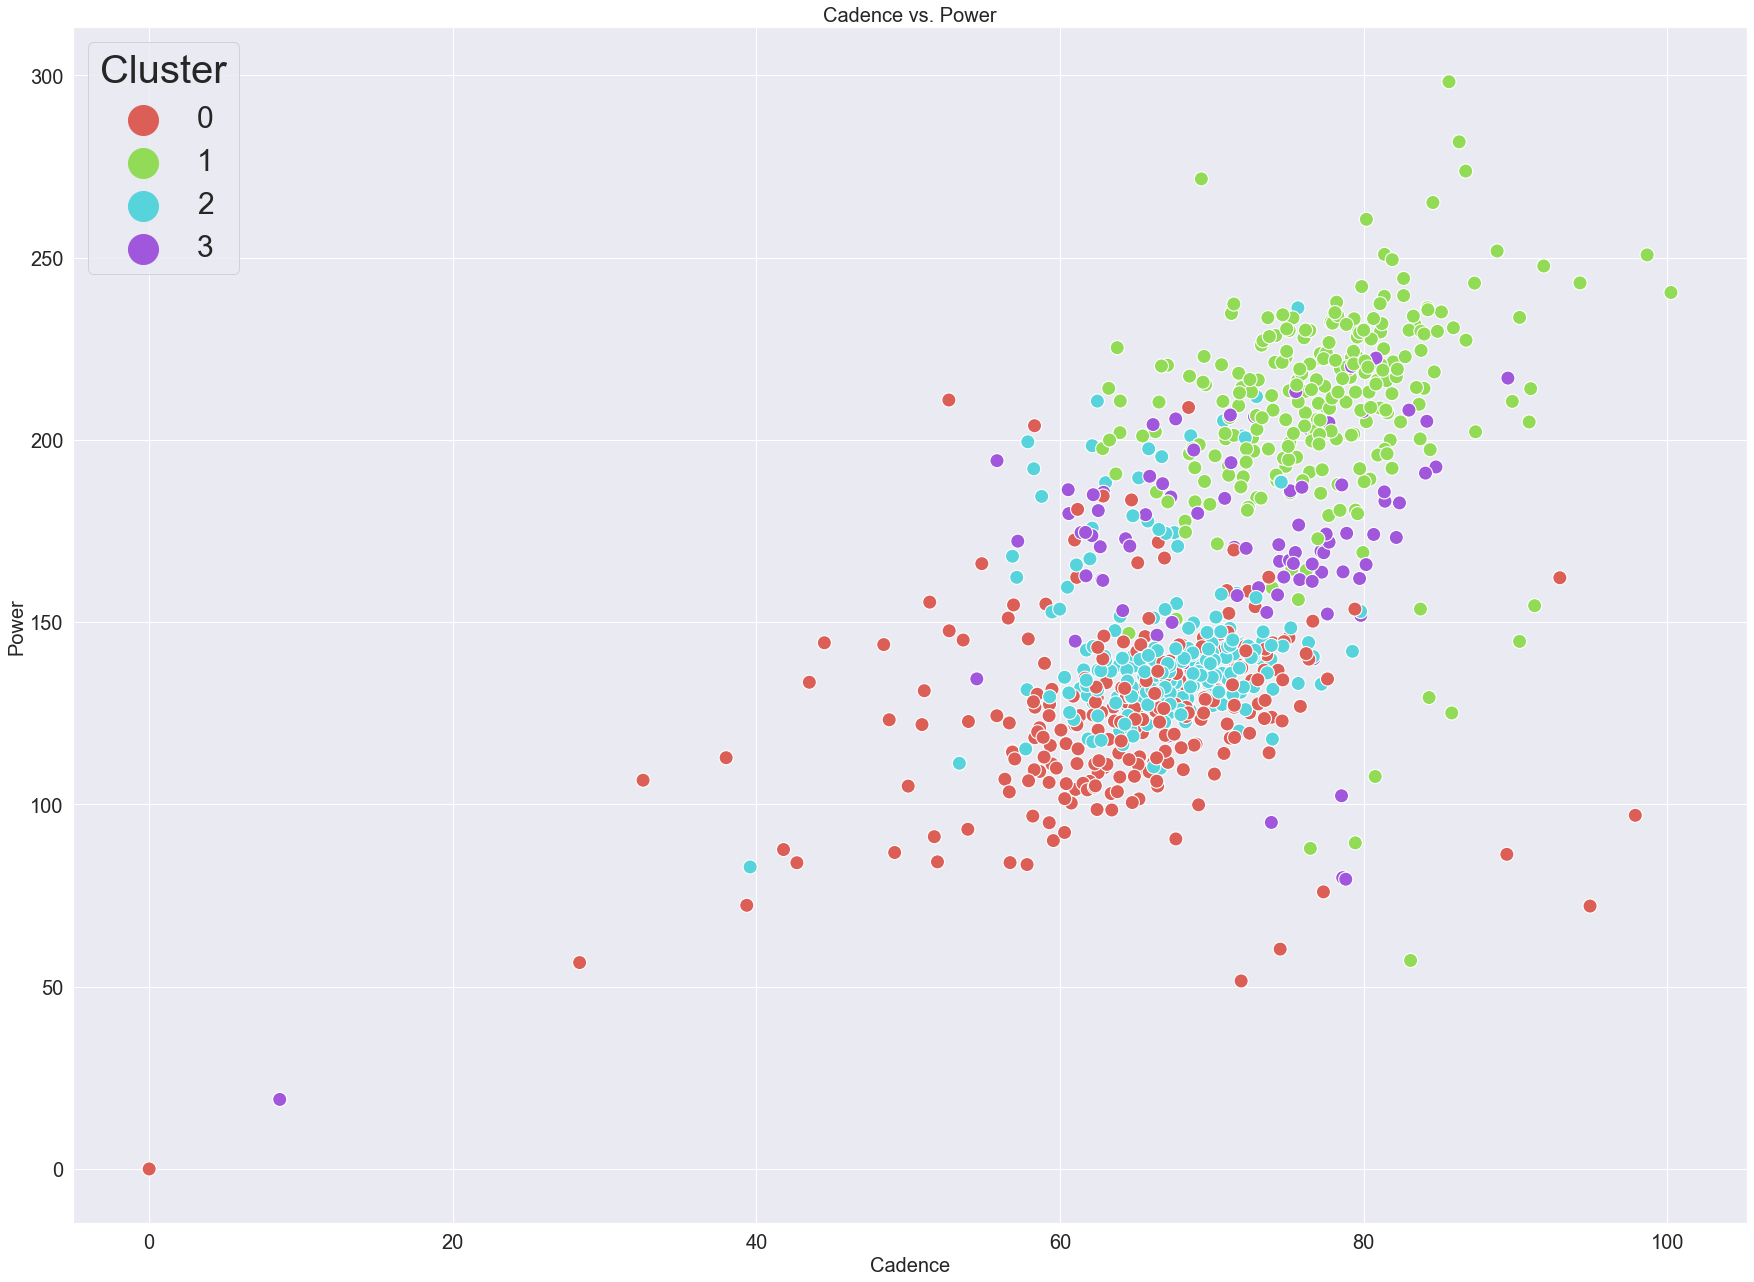

In [96]:
plot = sns.scatterplot(x=gp_data.cadence,y=gp_data.power,hue=gp_data.Cluster,
                palette=sns.color_palette("hls",n_clusters),data=gp_data, legend="full", s=200)
sns.set(rc={"figure.figsize":(30, 22)})
plot.axes.set_title("Cadence vs. Power", fontsize=20)
plot.set_xlabel("Cadence", fontsize=20)
plot.set_ylabel("Power", fontsize=20)
plot.legend(title='Cluster', fontsize='30', title_fontsize='40', markerscale=5)
plot.tick_params(labelsize=20)
mp.show()

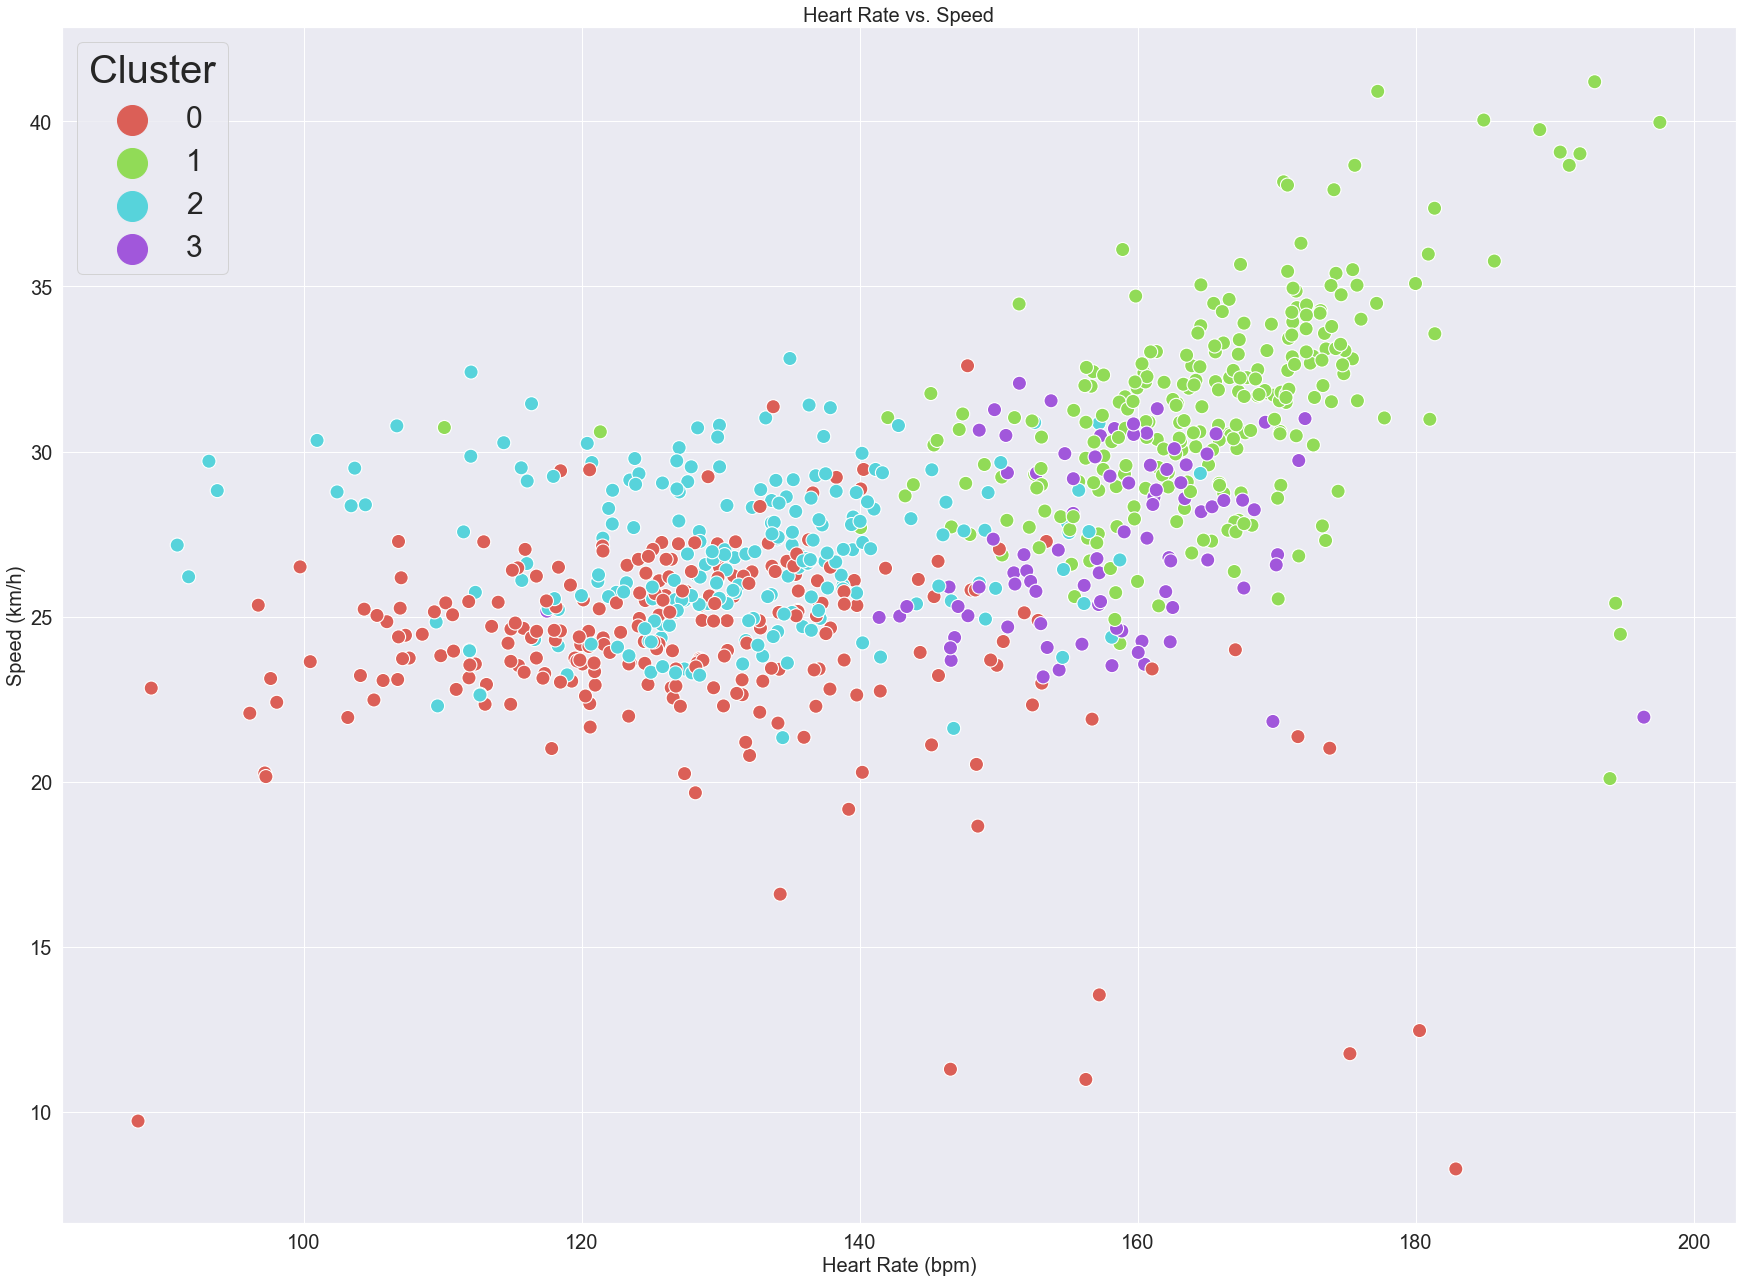

In [98]:
plot = sns.scatterplot(x=gp_data.heart_rate,y=gp_data.enhanced_speed,hue=gp_data.Cluster,
                palette=sns.color_palette("hls",n_clusters),data=gp_data, legend="full", s=200)
sns.set(rc={"figure.figsize":(30, 22)})
plot.axes.set_title("Heart Rate vs. Speed", fontsize=20)
plot.set_xlabel("Heart Rate (bpm)", fontsize=20)
plot.set_ylabel("Speed (km/h)", fontsize=20)
plot.legend(title='Cluster', fontsize='30', title_fontsize='40', markerscale=5)
plot.tick_params(labelsize=20)
mp.show()

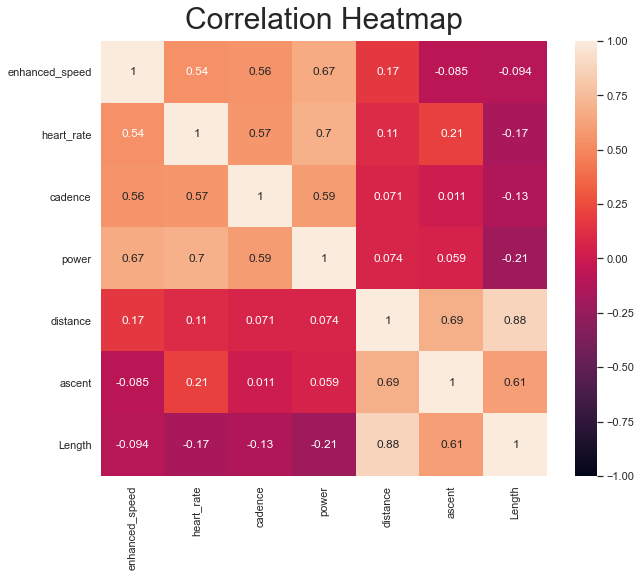

In [100]:
#Correlation Matrix Heatmap
heatmap = sns.heatmap(td_comb.corr(), vmin=-1, vmax=1, annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12);
sns.set(rc={"figure.figsize":(10, 8)})
mp.show()

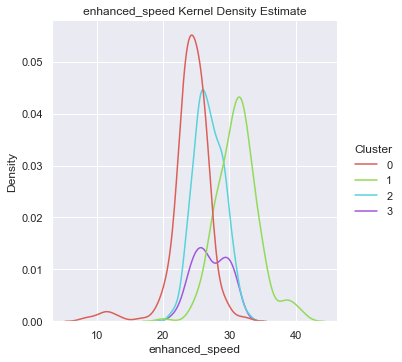

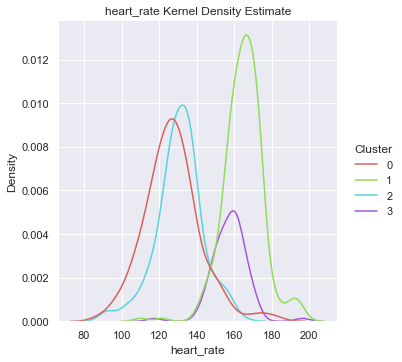

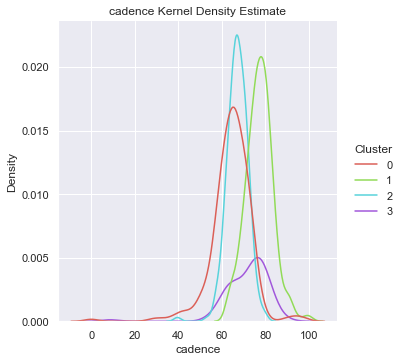

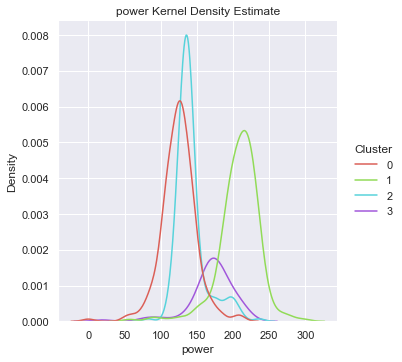

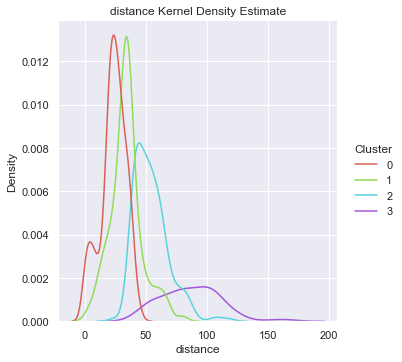

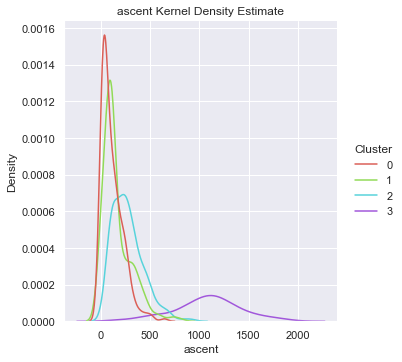

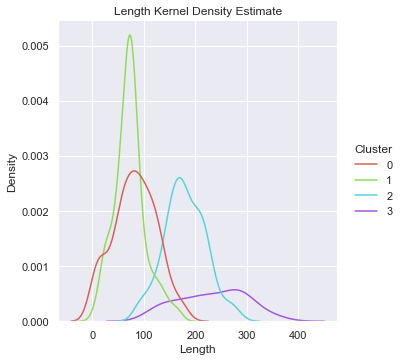

In [101]:
for i in gp_data.columns[1:]:
    hist = sns.displot(gp_data, x=i, hue="Cluster", kind="kde", 
                       palette=sns.color_palette("hls",n_clusters)).set(title=i + " Kernel Density Estimate")
    mp.show()

In [102]:
# save the model to disk
filename = 'clustering_model.sav'
joblib.dump(clusterer, filename)

filename = 'clustering_scaler.sav'
joblib.dump(scaler, filename)

['clustering_scaler.sav']